In [627]:
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import os
import re

In [628]:
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

In [629]:
from sudachipy import tokenizer
from sudachipy import dictionary
import fugashi
from collections import Counter

In [630]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

In [631]:
import nltk
from nltk.probability import FreqDist
from nltk.collocations import *

In [632]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#генерируем адреса страниц
search_results = ['https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page='+str (i) for i in range(1, 101)]

['https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=1', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=2', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=3', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=4', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=5', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=6', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=7', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=8', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=9', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=10', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=11', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=12', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=13', 'https:

In [86]:
def click_button (driver):
    try:
        Xpath = '//*[@id="erpc-half-modal"]/div/div/div[2]/div/button'
        ss = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, Xpath)))
        ss.click()
        time.sleep (1)
        return True
    except TimeoutException:
        return False

In [87]:
def find_vid (url, driver):
    '''ищем url новостей с видео'''
    driver.get(url)
    click_button (driver)
    updated_html = driver.page_source
    soup = BeautifulSoup(updated_html, 'html.parser')
    links_with_video = []
    all_links = soup.find_all('a', {'class': 'esl7kn2s i8ir4s4 i8ir4s9 _1yvyrz30'})
    for link in all_links:
        if link.find('div', {'class': 'oqol7i3'}):
            links_with_video.append(link['href'])
    return (links_with_video)

In [97]:
news_with_video = [] #для поиска всех ссылок на новости с видео в нашей выдаче
driver = webdriver.Chrome()
try:
  for i in tqdm(range(len(search_results))):
    new = find_vid(search_results[i], driver)
    news_with_video = news_with_video + new
finally:
    driver.quit()

100%|██████████| 100/100 [21:32<00:00, 12.93s/it]


In [98]:
print (f'В нашей выдаче {len(news_with_video)} новостей с видео')

В нашей выдаче 622 новостей с видео


In [ ]:
urls1 = [] #для поиска ссылок с нескольких первых страниц (дозагрузка новых текстов)
driver = webdriver.Chrome()
try:
  for i in range (0,5):
    new = find_vid(search_results[i], driver)
    urls1 = urls1 + new
finally:
    driver.quit()

In [91]:
def getNews(url):
   driver.get(url)
   click_button (driver)
   updated_html = driver.page_source
   soup = BeautifulSoup(updated_html, 'html.parser')
   title = soup.find_all ('meta', {'property' : "og:title"})[0].attrs['content']
   date = soup.find_all('time')[0].get('datetime')
   tags = soup.find_all('div', {'class':['nw--colored _1nidglr8 _1i1d7sh1', 
                                       'nw--border _1nidglrq _1i1d7sh1']})
   for tag in tags:
      for t in tag.find_all():
         t.extract()
   text_list = soup.find_all('p', {'class' : '_1i1d7sh2'})
   text = [i.text for i in text_list]
   final_text = ' '.join(text)
   return title, date, final_text, url

In [ ]:
driver = webdriver.Chrome()
all_news = []
try:
    for i in tqdm(range(len(news_with_video))): #для выгрузки всех новостей с видео
        new = getNews (news_with_video[i])
        all_news.append (new)
finally:
    driver.quit()

In [ ]:
df_all = pd.DataFrame(all_news)
df_all.columns = ['title', 'date', 'text', 'link'] #табличка со всеми новостями

In [92]:
driver = webdriver.Chrome()
news3 = []
try:
    for i in tqdm(range(len(urls1))): #для выгрузки последней порции новостей
        new = getNews (urls1[i])
        news3.append (new)
finally:
    driver.quit()

100%|██████████| 32/32 [06:19<00:00, 11.85s/it]


In [93]:
df_new = pd.DataFrame(news3)
df_new.columns = ['title', 'date', 'text', 'link'] #табличка только с последней порцией новостей

In [94]:
df = pd.read_excel('nhk_news_13jan.xlsx', index_col=0) # подгружаем уже собранный датасет
df = pd.concat ([df_new, df], axis = 0, ignore_index=True) #объединяем его с новой порцией текстов
df.drop_duplicates(inplace = True, ignore_index=True)

In [95]:
df.head(10)

,title,date,text,link
0,台湾 頼総統 “米と関係さらに深め 経済安全保障を強化” | NHKニュース,2026-02-03T16:50:21+09:00,台湾の頼清徳総統は、アメリカのトランプ政権と関税をめぐる交渉で合意したことを評価するとともに...,https://news.web.nhk/newsweb/na/na-k1001504244...
1,農林水産物と食品の輸出額 過去最高も政府目標届かず 課題は？ | NHKニュース,2026-02-03T09:21:54+09:00,去年1年間の農林水産物と食品の輸出額は1兆7000億円余りと13年連続で過去最高を更新しまし...,https://news.web.nhk/newsweb/na/na-k1001504213...
2,トランプ大統領 重要鉱物の民間企業利用へ備蓄制度開始を発表 | NHKニュース,2026-02-03T11:44:14+09:00,アメリカのトランプ大統領は、レアアースなどの重要鉱物を民間企業で利用するために日本円でおよそ...,https://news.web.nhk/newsweb/na/na-k1001504227...
3,ロシア ショイグ氏 日本について“軍事化加速させる政策注視” | NHKニュース,2026-02-02T08:00:42+09:00,ロシアの安全保障会議の書記を務めるショイグ氏は、中国の王毅外相と北京で会談し、日本について防...,https://news.web.nhk/newsweb/na/na-k1001504126...
4,パナマ運河 デンマークの海運大手の傘下企業が暫定的に運営へ | NHKニュース,2026-01-31T16:01:03+09:00,中米のパナマ政府は、海上輸送の要衝、パナマ運河の港湾を香港系の企業が運営するのは違憲だとする...,https://news.web.nhk/newsweb/na/na-k1001504049...
5,中国 1月の製造業の景況感指数 2か月ぶりに節目下回る | NHKニュース,2026-01-31T12:13:57+09:00,中国の今月の製造業の景況感を示す指数は、景気判断の節目となる「50」を2か月ぶりに下回りまし...,https://news.web.nhk/newsweb/na/na-k1001504039...
6,トランプ大統領 英中の経済協力強化に強い懸念 “非常に危険” | NHKニュース,2026-01-31T08:13:27+09:00,イギリスのスターマー首相が中国を訪問し、経済協力を強化することで合意したことについて、アメリ...,https://news.web.nhk/newsweb/na/na-k1001504020...
7,パナマ最高裁 “運河の香港系企業運営は違憲” 中国は反発 | NHKニュース,2026-01-31T08:04:10+09:00,中米パナマの最高裁判所は、海上輸送の要衝・パナマ運河の港湾を香港系の企業が運営するのは違憲だ...,https://news.web.nhk/newsweb/na/na-k1001504026...
8,トランプ大統領 カナダで製造の航空機 認証取り消す意向示す | NHKニュース,2026-01-30T14:06:50+09:00,アメリカとカナダの対立が続く中、トランプ大統領は、カナダで製造されるすべての航空機の認証を取...,https://news.web.nhk/newsweb/na/na-k1001503951...
9,日本で働く外国人 去年257万人余 初めて250万人超える 厚労省 | NHKニュース,2026-01-30T14:02:49+09:00,人口減少で働き手の確保が課題となるなか、日本で働く外国人労働者は、去年初めて250万人を超え...,https://news.web.nhk/newsweb/na/na-k1001503947...


In [96]:
df.to_excel ('nhk_news_3feb.xlsx')

In [446]:
df = pd.read_excel ('nhk_news_3feb.xlsx', index_col=0)

In [831]:
stop_words_fu = ['為る', '居る', '言う', '成る', 'つく', '巡る', '事', '物', '有る', '因る', '対する', '上', '中', '間', 
                 '際', '他', '内', '為', '無い', '述べる', '出来る', '行う', '行く', '来る', '見る', '日', '月', '月日', 
                 '今月', '先月', '年', '年間', '去年', '今年', '今後', '今回', '以降', 'パーセント-percent', '凡そ', '兆',
                 '億', '万', '側', '人', '前', '後', '共', '一方', '機', 'こう', '更に', '関する', 'どう', '午前', '午後', 
                 '様', '示す', '円', '万人', '念頭', '下旬', '中心', '発表', '保障', '分野', '面', '時間']
stop_words_su = ['為る', '居る', '言う', '成る', 'つく', '巡る', '有る', 'よる', 'こと', '物', '日', '今回', '月', '今月', 
                '先月', '月日', '年', '去年', '今年', '年間', '午前', '午後', '述べる', '行う', '行く', '来る', '出来る', 
                '見る', '対する', 'とも', '上', '際', '中', '他', '無い', '為', '凡そ', '%', '側', '人', '前', '後', '今後', 
                '以降', '一方', '兆', '億', '万', '機', '間', 'うち', 'こう', '更に', '関する', 'どう', 'よう', '示す', 
                '円', '万人', '念頭', '下旬', '中心', '発表', '保障', '分野', '面', '時間']

In [ ]:
print (f'В списке стоп-слов для токенизатора sudachi {len(stop_words_su)} слов')
print (f'В списке стоп-слов для токенизатора fugashi {len(stop_words_fu)} слов') #библиотека-"обертка" для MeCab

В списке стоп-слов для токенизатора sudachi 67 слов
В списке стоп-слов для токенизатора fugashi 67 слов


In [833]:
common = set(stop_words_su) & set(stop_words_fu)
print (f'У токенизатора fugashi есть такие леммы: {set(stop_words_fu) - common}')
print (f'В токенизаторе sudachi они выглядят вот так: {set(stop_words_su) - common}')

У токенизатора fugashi есть такие леммы: {'様', '因る', '事', '内', 'パーセント-percent', '共'}
В токенизаторе sudachi они выглядят вот так: {'よる', 'とも', 'よう', '%', 'うち', 'こと'}


In [834]:
def tokenize_su (text):
    text_without_punct = re.sub(r'[\n\d+\s%「」『』“”、。]', '', text)
    tokenizer_obj = dictionary.Dictionary().create()
    mode = tokenizer.Tokenizer.SplitMode.C
    tokenized = tokenizer_obj.tokenize(text_without_punct, mode)
    allowed_pos = [
    '名詞',       # Существительное
    '動詞',       # Глагол
    '形容詞',     # Прилагательное
    '形状詞'      # Полупредикативные прилагательные
    ]
    meaningful_tokens = []
    for token in tokenized:
        if token.part_of_speech()[0] in allowed_pos:
            meaningful_tokens.append(token.normalized_form())
    stop_words = stop_words_su
    clean_tokens = []
    for token in meaningful_tokens:
        if token not in stop_words:
            clean_tokens.append(token)
    return clean_tokens

In [835]:
df['tokens'] = df['text'].apply(tokenize_su)

In [836]:
df ['length'] = df ['tokens'].apply(len)
df ['frequent tokens'] = df['tokens'].apply(lambda x: Counter(x).most_common(10))

In [837]:
df.head(10)

,title,date,text,link,tokens,length,frequent tokens
0,台湾 頼総統 “米と関係さらに深め 経済安全保障を強化” | NHKニュース,2026-02-03T16:50:21+09:00,台湾の頼清徳総統は、アメリカのトランプ政権と関税をめぐる交渉で合意したことを評価するとともに...,https://news.web.nhk/newsweb/na/na-k1001504244...,"[台湾, 頼清徳, 総統, アメリカ, トランプ政権, 関税, 交渉, 合意, 評価, 双方...",102,"[(台湾, 5), (アメリカ, 5), (経済, 4), (総統, 3), (中国, 3)..."
1,農林水産物と食品の輸出額 過去最高も政府目標届かず 課題は？ | NHKニュース,2026-02-03T09:21:54+09:00,去年1年間の農林水産物と食品の輸出額は1兆7000億円余りと13年連続で過去最高を更新しまし...,https://news.web.nhk/newsweb/na/na-k1001504213...,"[農林, 水産物, 食品, 輸出額, 余り, 連続, 過去, 最高, 更新, 政府, 目標,...",384,"[(輸出, 24), (輸出額, 10), (アメリカ, 9), (目標, 8), (先, ..."
2,トランプ大統領 重要鉱物の民間企業利用へ備蓄制度開始を発表 | NHKニュース,2026-02-03T11:44:14+09:00,アメリカのトランプ大統領は、レアアースなどの重要鉱物を民間企業で利用するために日本円でおよそ...,https://news.web.nhk/newsweb/na/na-k1001504227...,"[アメリカ, トランプ大統領, レアアース, 重要, 鉱物, 民間, 企業, 利用, 日本円...",103,"[(民間, 5), (備蓄, 5), (制度, 5), (重要, 4), (鉱物, 4), ..."
3,ロシア ショイグ氏 日本について“軍事化加速させる政策注視” | NHKニュース,2026-02-02T08:00:42+09:00,ロシアの安全保障会議の書記を務めるショイグ氏は、中国の王毅外相と北京で会談し、日本について防...,https://news.web.nhk/newsweb/na/na-k1001504126...,"[ロシア, 安全, 会議, 書記, 務める, ショイグ, 中国, 王毅, 外相, 北京, 会...",95,"[(中国, 6), (ロシア, 4), (ショイグ, 4), (外相, 4), (会談, 4..."
4,パナマ運河 デンマークの海運大手の傘下企業が暫定的に運営へ | NHKニュース,2026-01-31T16:01:03+09:00,中米のパナマ政府は、海上輸送の要衝、パナマ運河の港湾を香港系の企業が運営するのは違憲だとする...,https://news.web.nhk/newsweb/na/na-k1001504049...,"[中米, パナマ, 政府, 海上, 輸送, 要衝, パナマ, 運河, 港湾, 香港, 企業,...",106,"[(パナマ, 7), (企業, 6), (運営, 5), (香港, 3), (違憲, 3),..."
5,中国 1月の製造業の景況感指数 2か月ぶりに節目下回る | NHKニュース,2026-01-31T12:13:57+09:00,中国の今月の製造業の景況感を示す指数は、景気判断の節目となる「50」を2か月ぶりに下回りまし...,https://news.web.nhk/newsweb/na/na-k1001504039...,"[中国, 製造業, 景況感, 指数, 景気, 判断, 節目, 箇月, 下回る, 不動産, 不...",97,"[(指数, 6), (節目, 5), (下回る, 5), (中国, 4), (製造業, 4)..."
6,トランプ大統領 英中の経済協力強化に強い懸念 “非常に危険” | NHKニュース,2026-01-31T08:13:27+09:00,イギリスのスターマー首相が中国を訪問し、経済協力を強化することで合意したことについて、アメリ...,https://news.web.nhk/newsweb/na/na-k1001504020...,"[イギリス, スターマー, 首相, 中国, 訪問, 経済, 協力, 強化, 合意, アメリカ...",97,"[(首相, 6), (中国, 6), (イギリス, 5), (スターマー, 5), (関係,..."
7,パナマ最高裁 “運河の香港系企業運営は違憲” 中国は反発 | NHKニュース,2026-01-31T08:04:10+09:00,中米パナマの最高裁判所は、海上輸送の要衝・パナマ運河の港湾を香港系の企業が運営するのは違憲だ...,https://news.web.nhk/newsweb/na/na-k1001504026...,"[中米, パナマ, 最高, 裁判所, 海上, 輸送, 要衝, パナマ, 運河, 港湾, 香港...",125,"[(企業, 7), (中国, 7), (パナマ, 6), (運河, 4), (香港, 4),..."
8,トランプ大統領 カナダで製造の航空機 認証取り消す意向示す | NHKニュース,2026-01-30T14:06:50+09:00,アメリカとカナダの対立が続く中、トランプ大統領は、カナダで製造されるすべての航空機の認証を取...,https://news.web.nhk/newsweb/na/na-k1001503951...,"[アメリカ, カナダ, 対立, 続く, トランプ大統領, カナダ, 製造, 全て, 航空機,...",131,"[(カナダ, 11), (アメリカ, 8), (航空機, 6), (認証, 6), (トラン..."
9,日本で働く外国人 去年257万人余 初めて250万人超える 厚労省 | NHKニュース,2026-01-30T14:02:49+09:00,人口減少で働き手の確保が課題となるなか、日本で働く外国人労働者は、去年初めて250万人を超え...,https://news.web.nhk/newsweb/na/na-k1001503947...,"[人口, 減少, 働き手, 確保, 課題, 日本, 働く, 外国人労働者, 越える, 多い,...",103,"[(働き手, 3), (働く, 3), (外国人労働者, 3), (越える, 3), (多い..."


In [839]:
df.to_excel ('nhk_news_3feb_tokens_length.xlsx')

In [840]:
print (df['length'].describe())

count     726.000000
mean      180.851240
std       163.650746
min        11.000000
25%       101.000000
50%       120.000000
75%       194.000000
max      1807.000000
Name: length, dtype: float64


In [ ]:
df_final = df[df['length'] < 813].copy() #убираем 5 самых длинных новостей

In [842]:
print(f"Осталось данных: {len(df_final) / len(df) * 100:.1f}% от оригинала")

Осталось данных: 99.3% от оригинала


In [843]:
print (df_final['length'].describe())

count    721.000000
mean     173.380028
std      133.312466
min       11.000000
25%      101.000000
50%      120.000000
75%      190.000000
max      812.000000
Name: length, dtype: float64


In [844]:
all_tokens = df_final['tokens'].sum()

In [845]:
print (f'Используя наш основной токенизатор sudachi, мы найдем в корпусе {len(all_tokens)} токенов и {len(set(all_tokens))} уникальных токенов')

Используя наш основной токенизатор sudachi, мы найдем в корпусе 125007 токенов и 9604 уникальных токенов


In [846]:
word_frequencies = FreqDist(all_tokens)

In [883]:
word_frequencies.most_common(50)

[('中国', 4132),
 ('アメリカ', 1520),
 ('日本', 1503),
 ('政府', 791),
 ('会談', 665),
 ('ロシア', 636),
 ('台湾', 634),
 ('関税', 627),
 ('関係', 589),
 ('経済', 500),
 ('大統領', 466),
 ('措置', 457),
 ('強化', 456),
 ('企業', 436),
 ('首脳', 420),
 ('総理大臣', 415),
 ('トランプ大統領', 399),
 ('貿易', 393),
 ('国', 391),
 ('安全', 387),
 ('ウクライナ', 384),
 ('協力', 377),
 ('求める', 375),
 ('影響', 365),
 ('国家', 361),
 ('対応', 360),
 ('確認', 358),
 ('輸出', 352),
 ('受ける', 347),
 ('向ける', 332),
 ('感染', 331),
 ('拡大', 322),
 ('考え', 320),
 ('世界', 317),
 ('明らか', 303),
 ('進める', 302),
 ('主席', 290),
 ('協議', 289),
 ('輸入', 286),
 ('続く', 285),
 ('国際', 284),
 ('地域', 282),
 ('軍事', 282),
 ('会見', 274),
 ('話す', 274),
 ('必要', 267),
 ('伝える', 267),
 ('訪問', 266),
 ('開く', 263),
 ('政策', 261)]

In [848]:
def tokenize_fu (text):
    text_without_punct = re.sub(r'[\n\d+\s%「」『』“”、。]', '', text)
    tagger = fugashi.Tagger()
    tokenized = tagger (text_without_punct)
    allowed_pos = [
    '名詞',       # Существительное
    '動詞',       # Глагол
    '形容詞',     # Прилагательное
    '形状詞'      # Полупредикативные прилагательные
    ]
    meaningful_tokens = []
    for word in tokenized:
        if word.feature.pos1 in allowed_pos:
            meaningful_tokens.append(word.feature.lemma)
    stop_words = stop_words_fu
    clean_tokens = []
    for token in meaningful_tokens:
        if token not in stop_words and token is not None:
            clean_tokens.append(token)
    return clean_tokens

In [849]:
all_texts = df_final['text'].str.cat()
all_tokenized = tokenize_fu (all_texts)

In [850]:
print (f'Токенизатор fugashi найдет в корпусе {len (all_tokenized)} токенов и {len (set(all_tokenized))} уникальных токенов')

Токенизатор fugashi найдет в корпусе 129326 токенов и 7917 уникальных токенов


In [851]:
print (Counter (all_tokenized).most_common(100))

[('中国', 4243), ('日本', 1837), ('アメリカ-America', 1599), ('大統領', 880), ('政府', 795), ('トランプ-trump', 747), ('関係', 728), ('会談', 665), ('経済', 654), ('大臣', 651), ('関税', 647), ('ロシア-Rossiya', 636), ('タイワン', 635), ('企業', 487), ('感染', 472), ('措置', 458), ('強化', 456), ('安全', 452), ('総理', 430), ('首脳', 420), ('貿易', 419), ('影響', 418), ('輸出', 401), ('協力', 400), ('国際', 399), ('国', 392), ('ウクライナ-Ukraina', 384), ('輸入', 378), ('求める', 375), ('軍事', 368), ('国家', 368), ('政権', 367), ('対応', 367), ('世界', 365), ('確認', 361), ('受ける', 347), ('外務', 335), ('記者', 332), ('向ける', 332), ('コロナ-corona', 326), ('重要', 325), ('拡大', 322), ('考え', 320), ('主席', 305), ('訪問', 304), ('進める', 303), ('明らか', 303), ('軍', 303), ('地域', 300), ('協議', 295), ('必要', 291), ('続く', 285), ('会見', 274), ('会議', 274), ('話す', 274), ('防衛', 272), ('両国', 271), ('当局', 269), ('アジア-Asia', 267), ('伝える', 267), ('開く', 263), ('政策', 261), ('懸念', 261), ('取る', 259), ('訪れる', 255), ('強調', 253), ('問題', 253), ('可能', 253), ('追加', 250), ('連携', 247), ('活動', 247), ('対策', 233), 

In [852]:
tokens_by_article = df_final['tokens']

In [853]:
def news_tokenizer (text):
    return (text)

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer=news_tokenizer, #загружаем в векторайзер уже токенизированный ранее текст
    preprocessor=news_tokenizer,
    token_pattern=None
)

X = tfidf.fit_transform(tokens_by_article)

In [855]:
X.shape

(721, 9604)

In [ ]:
#этот кусок кода для меня написал ИИ
feature_names = np.array(tfidf.get_feature_names_out())
top_tfidf = []
for row in X:
    # Превращаем строку разреженной матрицы в массив
    row_data = row.toarray().flatten()
    # Находим индексы топ-10 значений
    top_indices = np.argsort(row_data)[-10:][::-1]
    # Извлекаем слова, вес которых больше 0
    top_words = [feature_names[i] for i in top_indices if row_data[i] > 0]
    top_tfidf.append(top_words)

In [857]:
df_final['top 10 tf-idf'] = top_tfidf

In [858]:
df_final.head(10)

,title,date,text,link,tokens,length,frequent tokens,top 10 tf-idf
0,台湾 頼総統 “米と関係さらに深め 経済安全保障を強化” | NHKニュース,2026-02-03T16:50:21+09:00,台湾の頼清徳総統は、アメリカのトランプ政権と関税をめぐる交渉で合意したことを評価するとともに...,https://news.web.nhk/newsweb/na/na-k1001504244...,"[台湾, 頼清徳, 総統, アメリカ, トランプ政権, 関税, 交渉, 合意, 評価, 双方...",102,"[(台湾, 5), (アメリカ, 5), (経済, 4), (総統, 3), (中国, 3)...","[総統, 台湾, 経済, 頼清徳, 評価, アメリカ, 深める, 双方, 交流, 羨む]"
1,農林水産物と食品の輸出額 過去最高も政府目標届かず 課題は？ | NHKニュース,2026-02-03T09:21:54+09:00,去年1年間の農林水産物と食品の輸出額は1兆7000億円余りと13年連続で過去最高を更新しまし...,https://news.web.nhk/newsweb/na/na-k1001504213...,"[農林, 水産物, 食品, 輸出額, 余り, 連続, 過去, 最高, 更新, 政府, 目標,...",384,"[(輸出, 24), (輸出額, 10), (アメリカ, 9), (目標, 8), (先, ...","[輸出, 輸出額, 目標, 先, 多角化, 届く, 農林, 売り上げ, 食品, 増える]"
2,トランプ大統領 重要鉱物の民間企業利用へ備蓄制度開始を発表 | NHKニュース,2026-02-03T11:44:14+09:00,アメリカのトランプ大統領は、レアアースなどの重要鉱物を民間企業で利用するために日本円でおよそ...,https://news.web.nhk/newsweb/na/na-k1001504227...,"[アメリカ, トランプ大統領, レアアース, 重要, 鉱物, 民間, 企業, 利用, 日本円...",103,"[(民間, 5), (備蓄, 5), (制度, 5), (重要, 4), (鉱物, 4), ...","[備蓄, 制度, 民間, 鉱物, レアアース, 利用, 下げる, 依存度, 重要, 企業]"
3,ロシア ショイグ氏 日本について“軍事化加速させる政策注視” | NHKニュース,2026-02-02T08:00:42+09:00,ロシアの安全保障会議の書記を務めるショイグ氏は、中国の王毅外相と北京で会談し、日本について防...,https://news.web.nhk/newsweb/na/na-k1001504126...,"[ロシア, 安全, 会議, 書記, 務める, ショイグ, 中国, 王毅, 外相, 北京, 会...",95,"[(中国, 6), (ロシア, 4), (ショイグ, 4), (外相, 4), (会談, 4...","[ショイグ, 外相, 軍事化, 増額, ロシア, 防衛費, 王, 会談, 書記, 感]"
4,パナマ運河 デンマークの海運大手の傘下企業が暫定的に運営へ | NHKニュース,2026-01-31T16:01:03+09:00,中米のパナマ政府は、海上輸送の要衝、パナマ運河の港湾を香港系の企業が運営するのは違憲だとする...,https://news.web.nhk/newsweb/na/na-k1001504049...,"[中米, パナマ, 政府, 海上, 輸送, 要衝, パナマ, 運河, 港湾, 香港, 企業,...",106,"[(パナマ, 7), (企業, 6), (運営, 5), (香港, 3), (違憲, 3),...","[パナマ, 運営, 違憲, 傘下, 企業, デンマーク, 選定, 裁判所, 海運, 暫定的]"
5,中国 1月の製造業の景況感指数 2か月ぶりに節目下回る | NHKニュース,2026-01-31T12:13:57+09:00,中国の今月の製造業の景況感を示す指数は、景気判断の節目となる「50」を2か月ぶりに下回りまし...,https://news.web.nhk/newsweb/na/na-k1001504039...,"[中国, 製造業, 景況感, 指数, 景気, 判断, 節目, 箇月, 下回る, 不動産, 不...",97,"[(指数, 6), (節目, 5), (下回る, 5), (中国, 4), (製造業, 4)...","[指数, 節目, 下回る, 製造業, 景況感, 内需, 企業, 不況, 停滞, 長期化]"
6,トランプ大統領 英中の経済協力強化に強い懸念 “非常に危険” | NHKニュース,2026-01-31T08:13:27+09:00,イギリスのスターマー首相が中国を訪問し、経済協力を強化することで合意したことについて、アメリ...,https://news.web.nhk/newsweb/na/na-k1001504020...,"[イギリス, スターマー, 首相, 中国, 訪問, 経済, 協力, 強化, 合意, アメリカ...",97,"[(首相, 6), (中国, 6), (イギリス, 5), (スターマー, 5), (関係,...","[スターマー, 首相, イギリス, 関係, 事前, 危険, 強化, 意義, 訪問, トランプ..."
7,パナマ最高裁 “運河の香港系企業運営は違憲” 中国は反発 | NHKニュース,2026-01-31T08:04:10+09:00,中米パナマの最高裁判所は、海上輸送の要衝・パナマ運河の港湾を香港系の企業が運営するのは違憲だ...,https://news.web.nhk/newsweb/na/na-k1001504026...,"[中米, パナマ, 最高, 裁判所, 海上, 輸送, 要衝, パナマ, 運河, 港湾, 香港...",125,"[(企業, 7), (中国, 7), (パナマ, 6), (運河, 4), (香港, 4),...","[パナマ, 運河, 契約, 企業, 香港, 違憲, 下す, 運営, 影響下, 判断]"
8,トランプ大統領 カナダで製造の航空機 認証取り消す意向示す | NHKニュース,2026-01-30T14:06:50+09:00,アメリカとカナダの対立が続く中、トランプ大統領は、カナダで製造されるすべての航空機の認証を取...,https://news.web.nhk/newsweb/na/na-k1001503951...,"[アメリカ, カナダ, 対立, 続く, トランプ大統領, カナダ, 製造, 全て, 航空機,...",131,"[(カナダ, 11), (アメリカ, 8), (航空機, 6), (認証, 6), (トラン...","[カナダ, 認証, 航空機, ボンバルディア, アメリカ, 製造, 取り消す, トランプ大統..."
9,日本で働く外国人 去年257万人余 初めて250万人超える 厚労省 | NHKニュース,2026-01-30T14:02:49+09:00,人口減少で働き手の確保が課題となるなか、日本で働く外国人労働者は、去年初めて250万人を超え...,https://news.web.nhk/newsweb/na/na-k1001503947...,"[人口, 減少, 働き手, 確保, 課題, 日本, 働く, 外国人労働者, 越える, 多い,...",103,"[(働き手, 3), (働く, 3), (外国人労働者, 3), (越える, 3), (多い...","[外国人労働者, 働き手, 厚生労働省, 働く, 就労, 外国人, 越える, 全国, 雇用,..."


In [859]:
df_final.to_excel('nhk_news_3feb_tokens_tfidf.xlsx')

In [860]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

bigram_finder = BigramCollocationFinder.from_words(all_tokens)
student = bigram_finder.score_ngrams(bigram_measures.student_t)

bigramstudent_df = pd.DataFrame([' '.join([bigram[0][0], bigram[0][1]]), bigram[0][0], bigram[0][1], bigram[1]] for bigram in student)
bigramstudent_df.columns = ['bigram', 'word_1', 'word_2', 't-score']
bigramstudent_df.sort_values(by='t-score', inplace=True, ascending=False, ignore_index=True)
bigramstudent_df.head(35)

,bigram,word_1,word_2,t-score
0,中国 政府,中国,政府,14.907099
1,追加 関税,追加,関税,14.715611
2,記者 会見,記者,会見,14.659206
3,首脳 会談,首脳,会談,13.840409
4,国家 主席,国家,主席,13.723292
5,習近平 国家,習近平,国家,13.594138
6,高市 総理大臣,高市,総理大臣,12.246060
7,中国 外務省,中国,外務省,11.791723
8,関税 措置,関税,措置,11.595406
9,中国 軍,中国,軍,11.046706


In [861]:
keywords = ['中国', '台湾', '安全', '経済', '強化', '軍事'] # перевод: Китай, Тайвань, безопасность, экономика, усиление, военный

In [862]:
for word in keywords:
    bigram_win_finder = BigramCollocationFinder.from_words(all_tokens, window_size=5)
    bigram_win_finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2) or w1 == w2)
    top_collocations = bigram_win_finder.score_ngrams(bigram_measures.likelihood_ratio)[:15]
    print(f"Топ-15 коллокаций для слова '{word}':")
    for i, (collocation, score) in enumerate(top_collocations, 1):
        print(f"{i}. {' '.join(collocation)} | LogLikelihoodRatio: {score:.4f}")
    print()

Топ-15 коллокаций для слова '中国':
1. 中国 外務省 | LogLikelihoodRatio: 75.3815
2. 中国 政府 | LogLikelihoodRatio: 68.7422
3. 中国 軍 | LogLikelihoodRatio: 60.8919
4. 中国 国家 | LogLikelihoodRatio: 47.1166
5. 中国 報道官 | LogLikelihoodRatio: 46.8003
6. 中国 局 | LogLikelihoodRatio: 39.4875
7. 中国 習近平 | LogLikelihoodRatio: 38.0451
8. 中国 追加 | LogLikelihoodRatio: 32.8313
9. 中国 統計 | LogLikelihoodRatio: 27.3232
10. 中国 主席 | LogLikelihoodRatio: 22.2726
11. 中国 共産党 | LogLikelihoodRatio: 22.2432
12. 中国 輸出 | LogLikelihoodRatio: 20.1965
13. 中国 輸入品 | LogLikelihoodRatio: 19.9503
14. 強める 中国 | LogLikelihoodRatio: 16.7745
15. 中国 剣 | LogLikelihoodRatio: 16.5373

Топ-15 коллокаций для слова '台湾':
1. 台湾 有事 | LogLikelihoodRatio: 111.1598
2. 台湾 国会 | LogLikelihoodRatio: 87.8792
3. 台湾 海峡 | LogLikelihoodRatio: 83.4624
4. 台湾 周辺 | LogLikelihoodRatio: 62.4840
5. 台湾 答弁 | LogLikelihoodRatio: 48.0273
6. 高市 台湾 | LogLikelihoodRatio: 45.2834
7. 台湾 頼清徳 | LogLikelihoodRatio: 44.7474
8. 台湾 総統 | LogLikelihoodRatio: 32.6085
9. 演習 台湾 | LogLikelihoo

In [ ]:
df_final ['month'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
words_by_month = pd.DataFrame(df_final.groupby('month')['text'].apply(' '.join)) #группируем тексты по месяцам
words_by_month ['number of news'] = df_final['month'].value_counts()
words_by_month['tokens'] = words_by_month['text'].apply(tokenize_fu)
words_by_month ['frequent tokens'] =  words_by_month['tokens'].apply(lambda x: Counter(x).most_common(35))

In [866]:
words_by_month

,text,number of news,tokens,frequent tokens
month,,,,
2022-03,新型コロナウイルスの感染が拡大している中国の上海では厳しい外出制限によって現地に住む日本人が...,3,"[新型, コロナ-corona, ウイルス-virus, 感染, 拡大, 中国, シャンハイ...","[(中国, 17), (シャンハイ, 17), (感染, 10), (ロシア-Rossiya..."
2022-04,中国では30日から5連休が始まりましたが、新型コロナウイルスの感染拡大で期間中に移動する人は...,9,"[中国, 連休, 始まる, 新型, コロナ-corona, ウイルス-virus, 感染, ...","[(感染, 58), (シャンハイ, 34), (制限, 34), (中国, 31), (外..."
2022-05,ロシアによるウクライナへの軍事侵攻などの影響を受けて、ことし10月までの肥料の価格が多くの種...,10,"[ロシア-Rossiya, ウクライナ-Ukraina, 軍事, 侵攻, 影響, 受ける, ...","[(中国, 38), (感染, 36), (コロナ-corona, 22), (制限, 20..."
2022-06,エアコンなど、いわゆる白物家電の先月の国内出荷額は、2か月連続で去年の同じ月を下回りました。...,7,"[エアコン-air conditioner, 白物, 家電, 国内, 出荷, 額, 箇月, ...","[(感染, 30), (制限, 28), (外出, 22), (中国, 21), (シャンハ..."
2022-07,中国の先月の新車の販売台数は、去年の同じ月と比べて23％余りの大幅な増加となり、新型コロナウ...,4,"[中国, 新車, 販売, 台数, 比べる, 余り, 大幅, 増加, 新型, コロナ-coro...","[(中国, 17), (大臣, 11), (便, 8), (感染, 7), (日本, 7),..."
2022-09,アメリカのバイデン大統領とイギリスのトラス首相は、ニューヨークで初めて対面の首脳会談を行い、...,3,"[アメリカ-America, バイデン-Biden, 大統領, イギリス-Inglez, ト...","[(中国, 18), (ロシア-Rossiya, 12), (首脳, 10), (会談, 1..."
2022-10,中国の今月の製造業の景況感を示す指数は景気判断の節目となる「50」を2か月ぶりに下回り、新型...,3,"[中国, 製造, 景況, 感, 指数, 景気, 判断, 節目, 箇月, 下回る, 新型, コ...","[(日本, 33), (旅行, 32), (安全, 17), (協力, 17), (コロナ-..."
2022-11,「ゼロコロナ」政策に対する大規模な抗議活動が起きた中国では、国内のネット上で抗議活動の写真や...,13,"[ゼロ-zero, コロナ-corona, 政策, 規模, 抗議, 活動, 起きる, 中国,...","[(中国, 60), (抗議, 43), (コロナ-corona, 40), (感染, 36..."
2022-12,ロシアのプーチン大統領は30日、中国の習近平国家主席とオンライン形式で会談し、来年の春、習主...,19,"[ロシア-Rossiya, プーチン-外国, 大統領, 中国, タイラ, 国家, 主席, オ...","[(感染, 109), (中国, 99), (コロナ-corona, 57), (対策, 4..."


In [ ]:
countries = ['中国', '日本', 'アメリカ-America', 'タイワン', 'ロシア-Rossiya', 'ウクライナ-Ukraina'] 
#Китай, Япония, США, Тайвань, Россия, Украина
persons = ['トランプ-trump', 'バイデン-Biden', '総理', '主席'] 
#Трамп, Байден, премьер-министр (Японии), председатель (КНР)
economic = ['貿易', '関税', 'レア-rare', '水産', '経済', '企業'] 
#внешняя торговля, пошлины, редко(земельные металлы), морепродукты, экономика, предприятия
security = ['安全', '軍', 'スパイ-spy', '事件'] #безопасность, армия (военный), шпион, инцидент
corona = ['感染', 'コロナ-corona', '制限'] #инфекция, корона(вирус), ограничения
mix = ['貿易', '関税', '経済', '軍', '感染'] #внешняя торговля, пошлины, экономика, армия (военный), инфекция

In [ ]:
def word_dynamics (df, words):
    '''функция создает таблицу, которая отражает динамику относительных частот заданных слов 
    (столбцы - слова, строки - месяцы)'''
    df_words = df.loc[:, ['tokens']]
    for i in words:
        df_words[f'{i}_freq'] = df_words['tokens'].apply(lambda x: x.count(i)/len(x))
    df_final = df_words.iloc[:, -len(words):]
    return (df_final)

In [870]:
df_countries = word_dynamics (words_by_month, countries)

In [ ]:
#с красивым графиком тоже немного помог ИИ
def graph (df, name):
    df_plot = df.reset_index().melt(id_vars='month', var_name='words', value_name='score')
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_plot, x='month', y='score', hue='words', linewidth=2)
    plt.title(name, fontsize=20, pad=20)
    font_name = 'Meiryo'
    font_prop = fm.FontProperties(family=font_name, size=12)
    plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
    all_months = df_plot['month'].unique()
    all_positions = np.arange(len(all_months))
    selected_positions = all_positions[::2]
    selected_labels = all_months[::2]
    plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
    plt.tight_layout()
    plt.show()

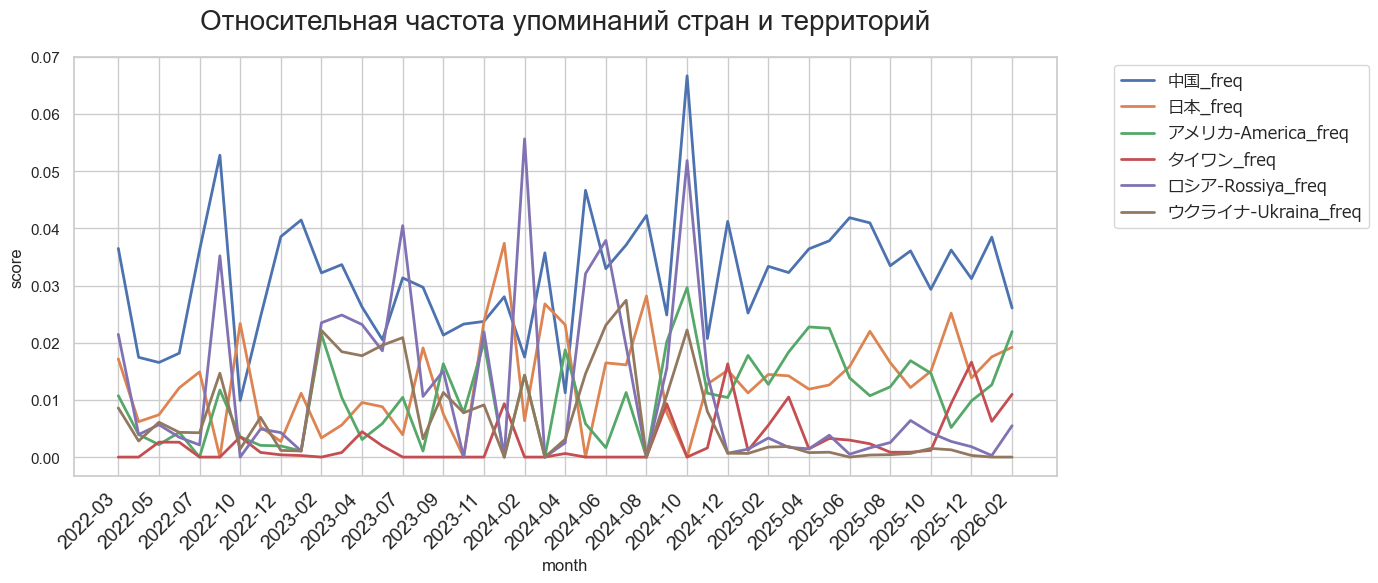

In [872]:
graph (df_countries, 'Относительная частота упоминаний стран и территорий')

In [873]:
df_persons = word_dynamics (words_by_month, persons)
df_persons['Президент США_freq'] = df_persons['トランプ-trump_freq'] + df_persons['バイデン-Biden_freq']
df_persons = df_persons.iloc[:, -3:]

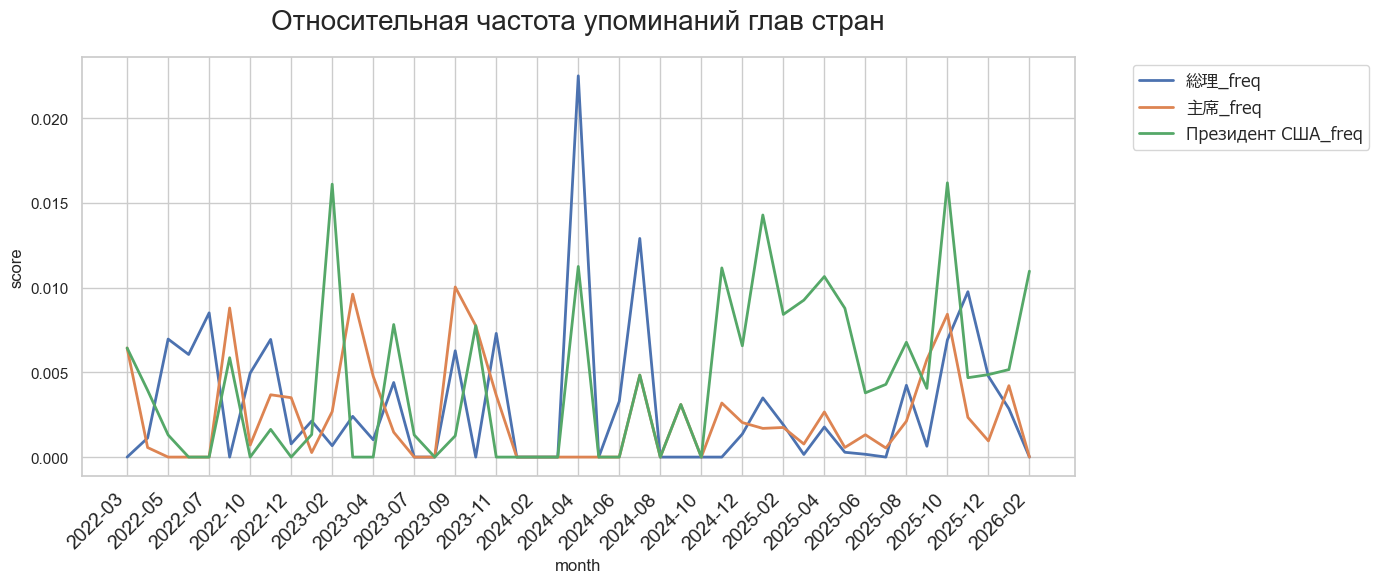

In [874]:
graph (df_persons, 'Относительная частота упоминаний глав стран')

In [875]:
df_economic = word_dynamics (words_by_month, economic)

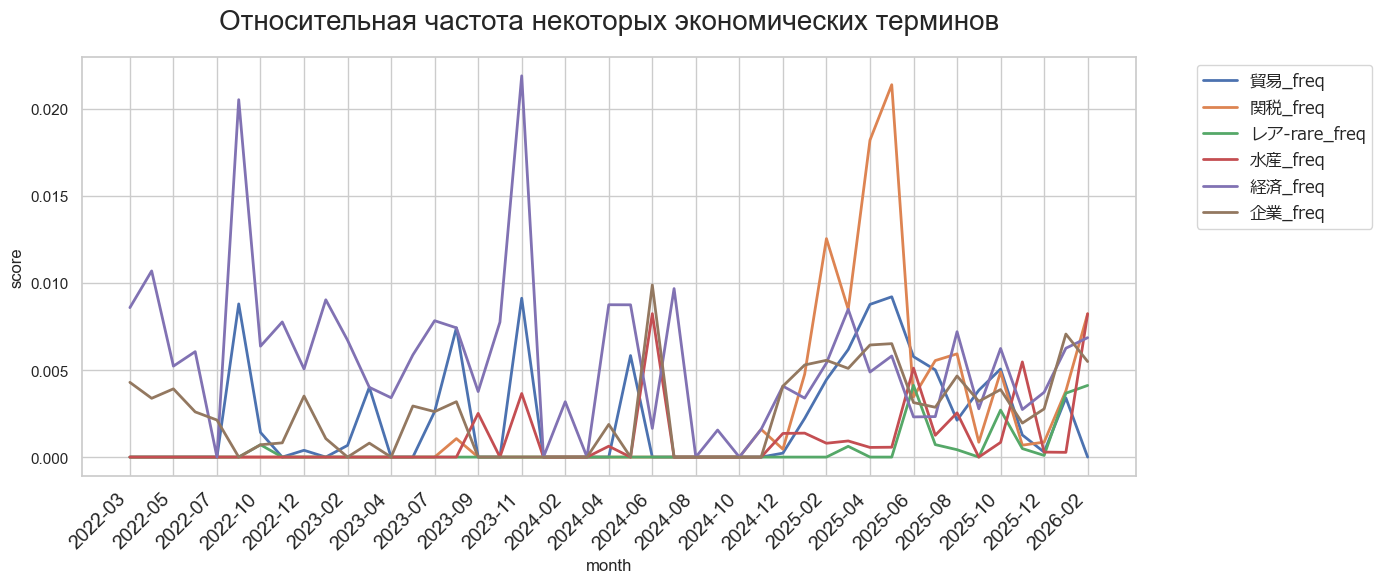

In [876]:
graph (df_economic, 'Относительная частота некоторых экономических терминов')

In [877]:
df_security = word_dynamics (words_by_month, security)

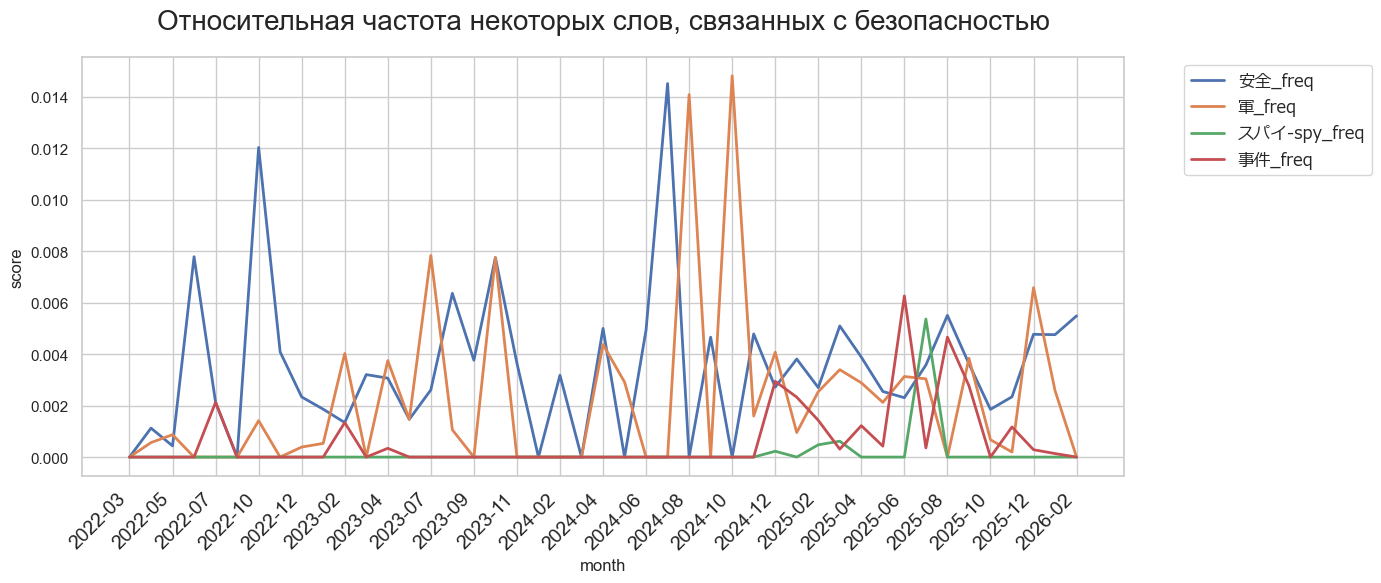

In [878]:
graph (df_security, 'Относительная частота некоторых слов, связанных с безопасностью')

In [879]:
df_corona = word_dynamics (words_by_month, corona)

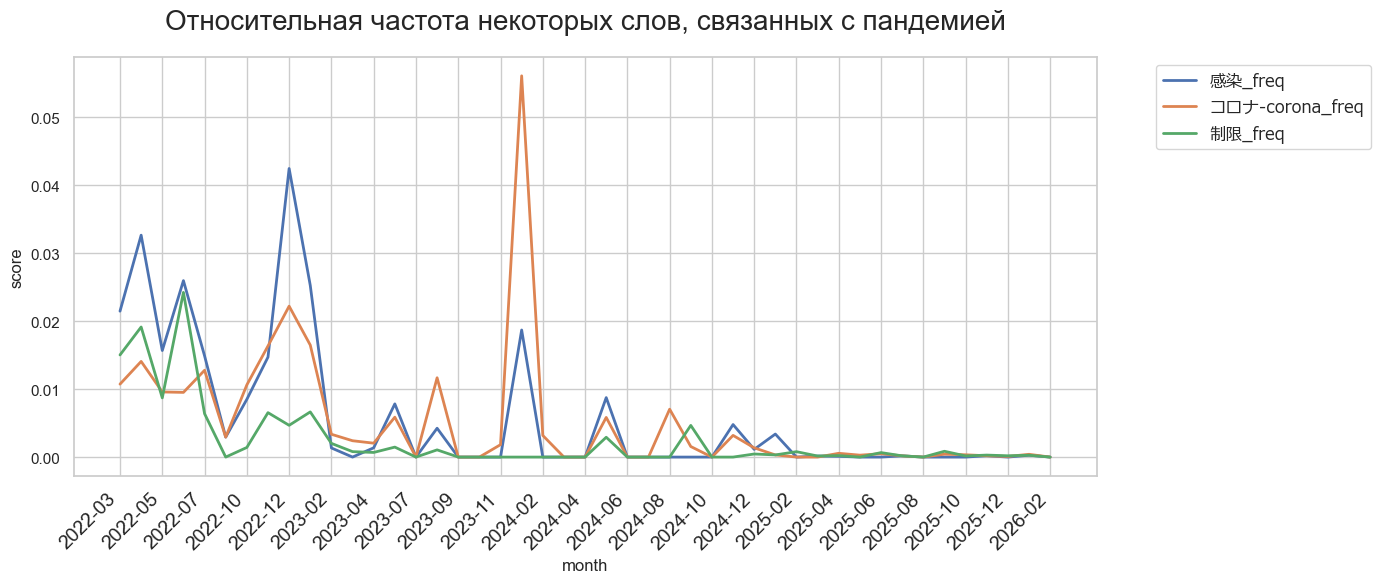

In [880]:
graph (df_corona, 'Относительная частота некоторых слов, связанных с пандемией')

In [881]:
df_mix = word_dynamics (words_by_month, mix)

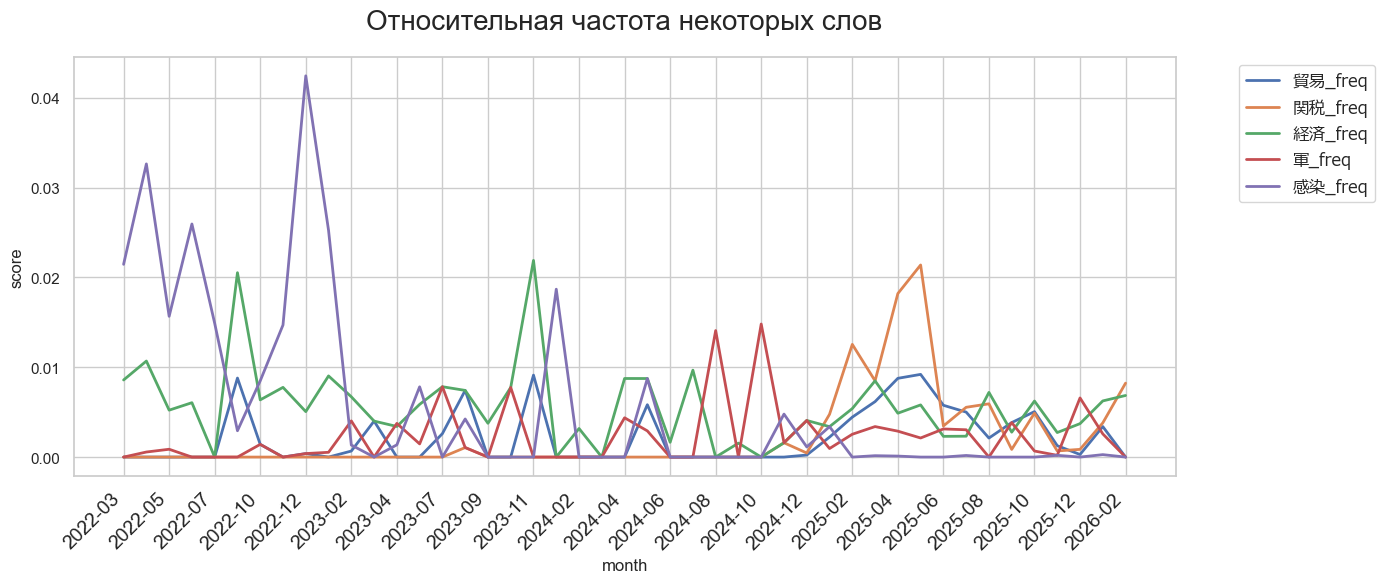

In [882]:
graph (df_mix, 'Относительная частота некоторых слов')